In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/storage/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.594336,0.893437,00:01
1,0.845016,0.680964,00:01
2,0.646316,0.669895,00:01


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [11]:
path=Config.data_path()/'ml-100k'
path

PosixPath('/storage/ml-100k')

In [12]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
len(ratings)

100000

In [15]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [16]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [17]:
data.show_batch()

userId,title,target
21,Paradise Lost: The Child Murders at Robin Hood Hills (1996),3.0
727,From Dusk Till Dawn (1996),1.0
868,Apocalypse Now (1979),4.0
263,Monty Python and the Holy Grail (1974),5.0
77,Crimson Tide (1995),3.0


In [18]:
y_range = [0,5.5]

In [19]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


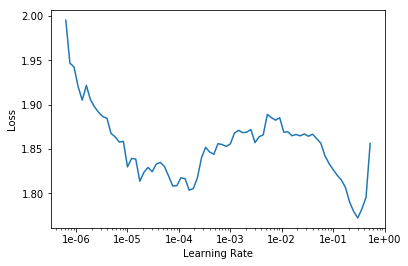

In [20]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,time
0,2.258040,2.370805,00:07
1,2.778975,2.816152,00:07
2,2.039458,1.931768,00:07
3,1.082589,1.065184,00:07
4,0.800987,0.877819,00:07


In [22]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [23]:
learn.load('dotprod');

In [24]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [25]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [26]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [27]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [28]:
item0 = lambda o:o[0]

In [29]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.6427),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.5720), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.5355), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.5239), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.5080), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.5050), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.4813),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.4612), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.4612), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.4556), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.4481), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.4465), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.4324), 'Grease 2 (1982)', 2.0),
 (tensor(-0.4300), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.4225), 'Free W

In [30]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.0141), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.9784), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.9383), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.9209), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.9150), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.9118), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.9062), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.8900), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.8586), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.8296), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.8291), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.8284), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.8271), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.8271), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.8155), 'Raiders of the Lost Ark (1981)', 4.252380952380952)]

### Movie weights

In [31]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [32]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [33]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [34]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9097), 'Saint, The (1997)'),
 (tensor(0.8971), 'Home Alone 3 (1997)'),
 (tensor(0.8292), 'American President, The (1995)'),
 (tensor(0.8155), 'Independence Day (ID4) (1996)'),
 (tensor(0.7982), 'First Knight (1995)'),
 (tensor(0.7975), 'Bio-Dome (1996)'),
 (tensor(0.7752), 'Multiplicity (1996)'),
 (tensor(0.7696), 'Milk Money (1994)'),
 (tensor(0.7680), 'Father of the Bride Part II (1995)'),
 (tensor(0.7622), 'Congo (1995)')]

In [35]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9431), 'Paths of Glory (1957)'),
 (tensor(-0.9356), 'Clockwork Orange, A (1971)'),
 (tensor(-0.8872), 'Chinatown (1974)'),
 (tensor(-0.8739),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.8586), 'Brazil (1985)'),
 (tensor(-0.8579), 'When We Were Kings (1996)'),
 (tensor(-0.8154), 'Taxi Driver (1976)'),
 (tensor(-0.7991), 'Ran (1985)'),
 (tensor(-0.7984), 'To Die For (1995)'),
 (tensor(-0.7966), '2001: A Space Odyssey (1968)')]

In [36]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [37]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.6824), 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (tensor(0.6205), 'Ruby in Paradise (1993)'),
 (tensor(0.5966), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.5923), 'Flipper (1996)'),
 (tensor(0.5895), 'Very Brady Sequel, A (1996)'),
 (tensor(0.5820), 'Hate (Haine, La) (1995)'),
 (tensor(0.5768), "McHale's Navy (1997)"),
 (tensor(0.5738), 'Adventures of Pinocchio, The (1996)'),
 (tensor(0.5700), 'Free Willy (1993)'),
 (tensor(0.5685), 'Beverly Hillbillies, The (1993)')]

In [38]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8317), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.7038), 'Empire Strikes Back, The (1980)'),
 (tensor(-0.6990), 'Braveheart (1995)'),
 (tensor(-0.6840), 'Sleepless in Seattle (1993)'),
 (tensor(-0.6714), "It's a Wonderful Life (1946)"),
 (tensor(-0.6671), "Schindler's List (1993)"),
 (tensor(-0.6369), 'Butch Cassidy and the Sundance Kid (1969)'),
 (tensor(-0.6051), 'E.T. the Extra-Terrestrial (1982)'),
 (tensor(-0.5963), 'Sneakers (1992)'),
 (tensor(-0.5882), 'Aladdin (1992)')]

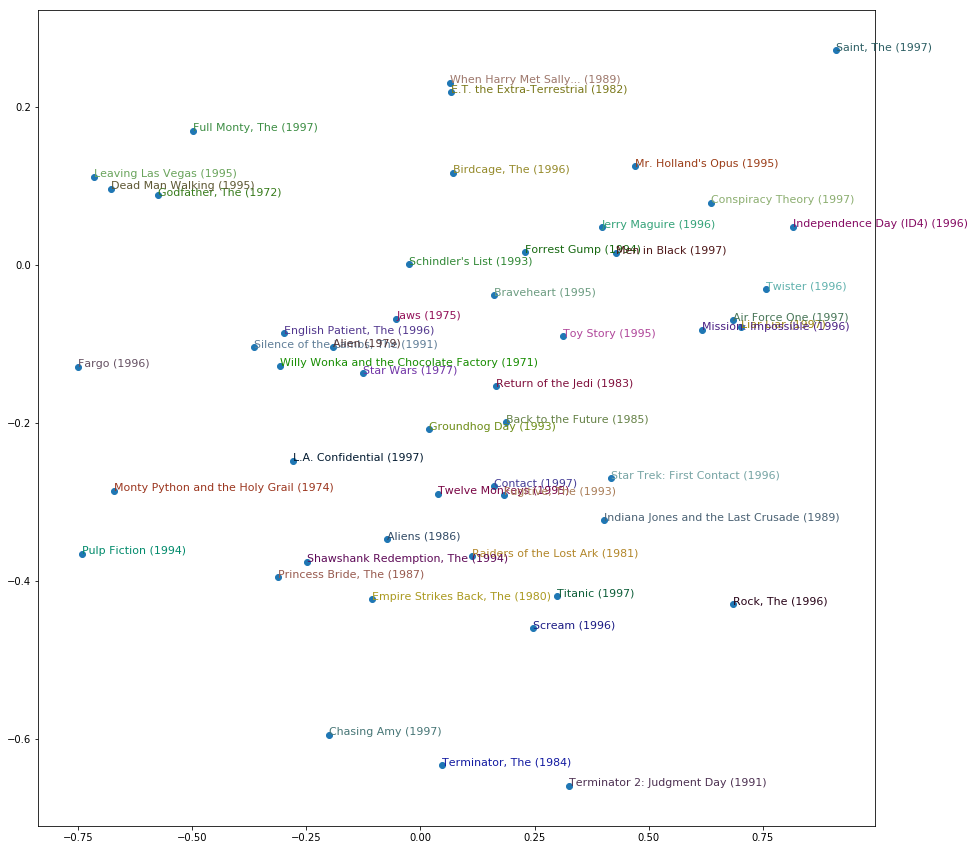

In [39]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()